In [1]:
!pip install transformers datasets evaluate seqeval

import os
import json
import numpy as np
from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=986c34ce9d51180ade234a849d92234c969339791f16296c63c94f1c87869c99
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.

# Config


In [2]:
model_checkpoint = "google/mobilebert-uncased"
num_epochs = 20
batch_size = 32
learning_rate = 0.0005

# Define your labels
entity_labels = ["HOSP", "PATIENT", "STAFF", "AGE", "DATE", "PHONE", "ID", "EMAIL", "LOC", "PATORG"]
all_labels = ["O"] + entity_labels
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Labels:", all_labels)


Labels: ['O', 'HOSP', 'PATIENT', 'STAFF', 'AGE', 'DATE', 'PHONE', 'ID', 'EMAIL', 'LOC', 'PATORG']


In [3]:

# Load dataset (adapt paths as needed)
data_files = {
    "train": "train.json",
    "validation": "validation.json"
}
raw_dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:

def align_spans_to_tokens(examples):
    texts = examples["text"]
    batch_tokenized = tokenizer(
        texts,
        truncation=True,
        return_offsets_mapping=True
    )

    new_labels = []
    for i, offsets in enumerate(batch_tokenized["offset_mapping"]):
        spans = examples["spans"][i]
        span_entities = [(s["start"], s["end"], s["label"]) for s in spans]

        token_labels = ["O"] * len(offsets)

        for span_start, span_end, span_label in span_entities:
            for idx, (token_start, token_end) in enumerate(offsets):
                if token_start == 0 and token_end == 0:
                    continue
                if token_end > span_start and token_start < span_end:
                    token_labels[idx] = span_label

        label_ids = [label2id[label] for label in token_labels]
        new_labels.append(label_ids)

    batch_tokenized["labels"] = new_labels
    batch_tokenized.pop("offset_mapping")
    return batch_tokenized


In [6]:
encoded_dataset = raw_dataset.map(
    align_spans_to_tokens,
    batched=True,
    remove_columns=raw_dataset["train"].column_names
)

Map:   0%|          | 0/673 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/95 [00:00<?, ? examples/s]

In [7]:

train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]


In [8]:

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForTokenClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device:", device)


device: cuda


In [10]:

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Use the new evaluate library
metric = evaluate.load("seqeval")


In [11]:

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for label_ids, pred_ids in zip(labels, predictions):
        # Only consider non-padding tokens (where label_ids != tokenizer.pad_token_id)
        # If you used -100 for ignored tokens, check that instead (e.g. if l != -100)
        filtered_labels = []
        filtered_preds = []
        for l, p_ in zip(label_ids, pred_ids):
          if l != -100:
              filtered_labels.append(id2label[l])
              filtered_preds.append(id2label[p_])

        true_labels.append(filtered_labels)
        true_predictions.append(filtered_preds)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"



training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("Evaluation:", metrics)

trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

In [13]:
training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("Evaluation:", metrics)

trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-13-ad0317562906>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.078301,0.875479,0.930754,0.902270,0.977846
2,No log,0.056290,0.886756,0.940937,0.913043,0.980138
3,No log,0.051696,0.889943,0.955193,0.921415,0.982047
4,No log,0.067074,0.885932,0.949084,0.916421,0.976318
5,No log,0.150866,0.807420,0.930754,0.864711,0.959511
6,No log,0.027340,0.969758,0.979633,0.974671,0.991597
7,No log,0.033100,0.944773,0.975560,0.959920,0.990069
8,No log,0.046106,0.921002,0.973523,0.946535,0.987013
9,No log,0.072161,0.887006,0.959267,0.921722,0.981665
10,No log,0.063673,0.904762,0.967413,0.935039,0.983193


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

Evaluation: {'eval_loss': 0.027339572086930275, 'eval_precision': 0.969758064516129, 'eval_recall': 0.9796334012219959, 'eval_f1': 0.9746707193515705, 'eval_accuracy': 0.9915966386554622, 'eval_runtime': 0.2552, 'eval_samples_per_second': 372.225, 'eval_steps_per_second': 11.754, 'epoch': 20.0}


('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

In [14]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Adjust these paths as necessary
model_path = "final_model"  # folder where your model was saved

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# If you have GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Suppose these were defined previously in your training script
# If not, load from config or define again:
# Example:
id2label = model.config.id2label
# id2label is a dictionary like {0: "O", 1: "HOSP", 2: "PATIENT", ...}

# Input sentence
sentence = """Immunization Report
Patient Name: Sandamali Herath
Patient ID: 6269540V
Date of Birth: March 15, 2010
Report ID: IMMU7890
Physician Name: Dr.Hemal Senanayake
Date of Report: April 10, 2024

Immunization Record
Vaccine Name	Date Administered	Dose	Site of Administration	Administered By
Hepatitis B	January 20, 2021	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
Influenza (Flu)	October 5, 2023	0.5 mL	Right Arm	Nurse Nuthara Pathirana
Measles-Mumps-Rubella	April 15, 2021	0.5 mL	Left Thigh	Dr.Hemal Senanayake
Tetanus (Tdap)	June 10, 2022	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
COVID-19 (Pfizer)	May 12, 2023	0.3 mL	Right Deltoid	Nurse Nuthara Pathirana
Notes
Upcoming Vaccines: HPV vaccine scheduled for June 2024.
Adverse Reactions: None reported for any administered vaccines.
Clinic Information:
Kalubowila Main Hospital
No 1, Kalubowila Hospital, Kalubowila, Colombo
Contact: (+94)6281110123"""
# sentence = "Patient Thejan Weerasekara, a 45-year-old male, who has patient ID 12434, was admitted to Saint Mary's Hospital on September 15, 2023, with symptoms of chest pain and shortness of breath. His wife, Jane Doe, reported that the symptoms had started suddenly the night before. Medical history includes hypertension and type 2 diabetes. The attending cardiologist, Dr. Smith, prescribed a course of treatment including medication and lifestyle adjustments."

# Tokenize
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, is_split_into_words=False)
# Move to GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits

# Get predicted label IDs
predictions = torch.argmax(logits, dim=2).cpu().numpy()[0]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0])

# Print token and predicted label
for token, pred_id in zip(tokens, predictions):
    label = id2label[pred_id]
    # Skip special tokens like [CLS], [SEP]
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t{label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


im	O
##mun	O
##ization	O
report	O
patient	O
name	O
:	O
sand	PATIENT
##ama	PATIENT
##li	PATIENT
her	PATIENT
##ath	PATIENT
patient	O
id	O
:	O
62	ID
##6	ID
##9	ID
##54	ID
##0	ID
##v	ID
date	O
of	O
birth	O
:	O
march	DATE
15	DATE
,	DATE
2010	DATE
report	O
id	O
:	O
im	ID
##mu	ID
##7	ID
##8	ID
##90	ID
physician	O
name	O
:	O
dr	STAFF
.	STAFF
hem	STAFF
##al	STAFF
sen	STAFF
##ana	STAFF
##ya	STAFF
##ke	STAFF
date	O
of	O
report	O
:	O
april	DATE
10	DATE
,	DATE
202	DATE
##4	DATE
im	O
##mun	O
##ization	O
record	O
vaccine	O
name	O
date	O
administered	O
dose	O
site	O
of	O
administration	O
administered	O
by	O
hepatitis	O
b	O
january	DATE
20	DATE
,	DATE
2021	DATE
0	O
.	O
5	O
ml	O
left	O
del	O
##to	O
##id	O
nurse	STAFF
kamal	STAFF
##a	STAFF
se	STAFF
##lva	STAFF
##raj	STAFF
influenza	O
(	O
flu	O
)	O
october	DATE
5	DATE
,	DATE
202	DATE
##3	DATE
0	O
.	O
5	O
ml	O
right	O
arm	O
nurse	STAFF
nut	STAFF
##hara	STAFF
path	STAFF
##ira	STAFF
##na	STAFF
me	O
##as	O
##les	O
-	O
mum	O
##ps	O
-	O
rub	O
##ella	O
april	DAT

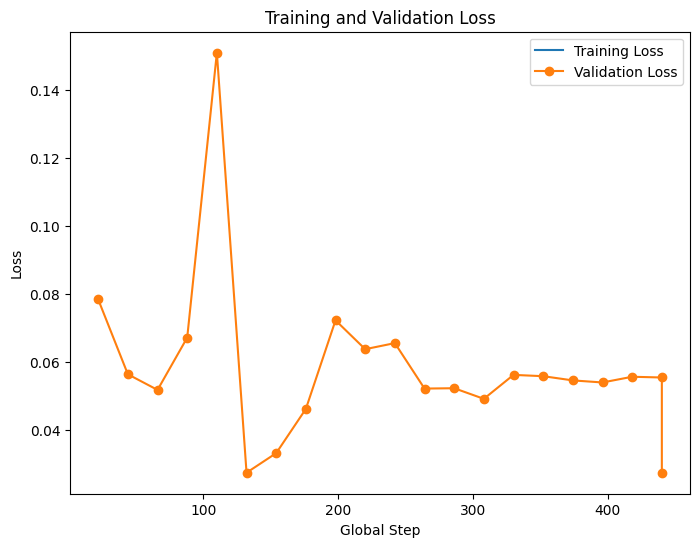

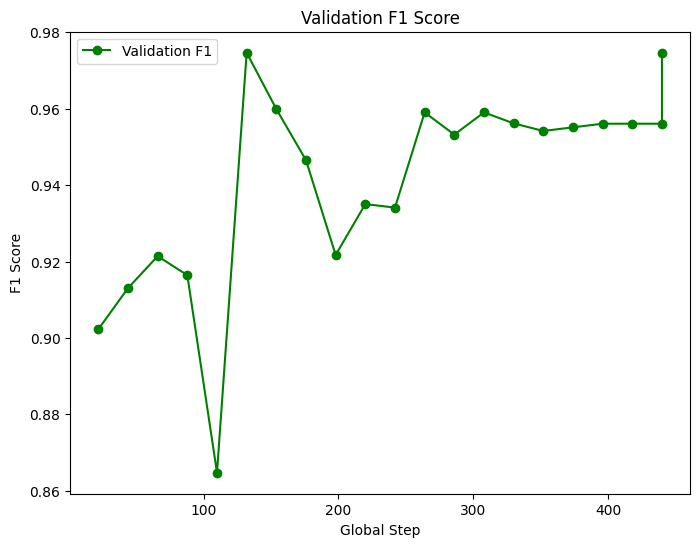

In [17]:
import matplotlib.pyplot as plt

# Extract the log history
log_history = trainer.state.log_history

# 1) Plot Training vs. Validation Loss
train_loss_vals = []
train_steps = []
eval_loss_vals = []
eval_steps = []

for entry in log_history:
    # Training loss entries
    if "loss" in entry and "step" in entry:
        train_loss_vals.append(entry["loss"])
        train_steps.append(entry["step"])
    # Evaluation loss entries
    if "eval_loss" in entry and "step" in entry:
        eval_loss_vals.append(entry["eval_loss"])
        eval_steps.append(entry["step"])

plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_loss_vals, label="Training Loss")
plt.plot(eval_steps, eval_loss_vals, label="Validation Loss", marker='o')
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 2) Plot F1 Score (or other metrics) over time
eval_f1_vals = []
eval_f1_steps = []

for entry in log_history:
    if "eval_f1" in entry and "step" in entry:
        eval_f1_vals.append(entry["eval_f1"])
        eval_f1_steps.append(entry["step"])

# Only plot if we actually have F1 data
if eval_f1_vals:
    plt.figure(figsize=(8, 6))
    plt.plot(eval_f1_steps, eval_f1_vals, label="Validation F1", marker='o', color='green')
    plt.xlabel("Global Step")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    plt.show()
